# 使用 LangGraph 构建基础聊天机器人

在本教程中，你将使用 LangGraph 构建一个基础的聊天机器人。这个聊天机器人将作为后续更高级教程的基础，我们将逐步添加更复杂的功能并介绍 LangGraph 的核心概念。

## 前置要求

在开始本教程之前，请确保你有一个支持工具调用功能的 LLM。在本例中，我们将使用通义千问的 Qwen 模型。

## 1. 安装必要的包

首先，让我们安装必要的包：

In [1]:
!pip install -U langgraph langsmith


  Attempting uninstall: langsmith

    Found existing installation: langsmith 0.3.42

    Uninstalling langsmith-0.3.42:

      Successfully uninstalled langsmith-0.3.42

   ---------------------------------------- 0/4 [langsmith]
   ---------------------------------------- 0/4 [langsmith]
   ---------------------------------------- 0/4 [langsmith]
   ---------------------------------------- 0/4 [langsmith]
   ---------------------------------------- 0/4 [langsmith]
   ---------------------------------------- 0/4 [langsmith]
  Attempting uninstall: langgraph-checkpoint
   ---------------------------------------- 0/4 [langsmith]
    Found existing installation: langgraph-checkpoint 2.0.25
   ---------------------------------------- 0/4 [langsmith]
    Uninstalling langgraph-checkpoint-2.0.25:
   ---------------------------------------- 0/4 [langsmith]
      Successfully uninstalled langgraph-checkpoint-2.0.25
   ---------------------------------------- 0/4 [langsmith]
   ---------- ---


## 2. 创建 StateGraph

现在我们将使用 LangGraph 创建一个基础的聊天机器人。这个聊天机器人将直接响应用户消息。

我们首先创建一个 StateGraph。StateGraph 对象将我们的聊天机器人定义为一个"状态机"。我们将添加节点来表示 LLM 和聊天机器人可以调用的函数，并添加边来指定机器人如何在这些函数之间转换。

State 类定义了我们的图的模式和用于处理状态更新的 reducer 函数。在我们的例子中，State 是一个 TypedDict，它有一个键：messages。add_messages reducer 函数用于将新消息追加到列表中，而不是覆盖它。

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

让我来解释一下 `Annotated` 的作用：

`Annotated` 是 Python 的类型提示（Type Hints）系统中的一个特殊类型，它允许我们为类型添加额外的元数据。在 LangGraph 的上下文中，它被用来定义状态更新的行为。

让我们详细分析代码中的使用：

```python
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list, add_messages]
```

这里 `Annotated` 的作用是：

1. **类型定义**：第一个参数 `list` 表示 `messages` 字段的类型是一个列表

2. **行为定义**：第二个参数 `add_messages` 是一个 reducer 函数，它定义了如何更新这个状态：
   - 当新的消息到来时，`add_messages` 会将这些消息追加到现有的消息列表中
   - 而不是简单地覆盖整个列表

举个例子来说明区别：

```python
# 不使用 Annotated 的情况
state = {"messages": ["消息1"]}
state["messages"] = ["消息2"]  # 这会覆盖之前的消息

# 使用 Annotated 和 add_messages 的情况
state = {"messages": ["消息1"]}
# 当新消息到来时，add_messages 会将其追加到列表中
# 结果会是 ["消息1", "消息2"]
```

在 LangGraph 中，这种设计特别有用，因为：
1. 它允许我们保持对话历史
2. 确保消息按顺序累积
3. 避免意外覆盖之前的消息

这就是为什么在聊天机器人中，我们使用 `Annotated[list, add_messages]` 来确保所有对话消息都被正确保存和累积。


## 3. 设置 LLM

我们将使用通义千问的 Qwen 模型作为我们的 LLM。让我们初始化它并用一个简单的消息测试它。

In [8]:
import os
from langchain_community.chat_models import ChatTongyi

llm = ChatTongyi(
    model="qwen-max"
)

llm.invoke("你好")


AIMessage(content='你好！有什么可以帮助你的吗？', additional_kwargs={}, response_metadata={'model_name': 'qwen-max', 'finish_reason': 'stop', 'request_id': 'ef0eb701-ff4f-94f9-b0fa-8bbd41bd1515', 'token_usage': {'input_tokens': 9, 'output_tokens': 7, 'total_tokens': 16, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--50c9b711-842e-47ce-8ad9-e4fcf9c73a45-0')


## 4. 添加聊天机器人节点

接下来，我们将添加一个"chatbot"节点。节点代表工作单元，通常是普通的 Python 函数。聊天机器人节点将使用我们的 LLM 来生成对用户消息的响应。


In [9]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)


## 5. 添加入口点

我们需要添加一个入口点来告诉图每次运行时从哪里开始工作。在这种情况下，我们将 START 节点连接到我们的聊天机器人节点。

In [10]:
graph_builder.add_edge(START, "chatbot")


## 6. 编译图

在运行图之前，我们需要编译它。这将创建一个 CompiledGraph，我们可以在我们的状态上调用它。

In [11]:
graph = graph_builder.compile()


## 7. 可视化图（可选）

你可以使用 get_graph 方法和其中一个"draw"方法来可视化图。这一步是可选的，需要额外的依赖项。

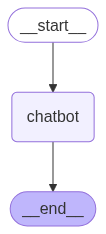

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass